## Generating series scaled to local grid by elevation
First, do everything from generate-timeseries.ipynb (and catchment-full_series_generation.py).

/opt/anaconda3/envs/stisp/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/opt/anaconda3/envs/stisp/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/opt/anaconda3/envs/stisp/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/opt/anaconda3/envs/stisp/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the n

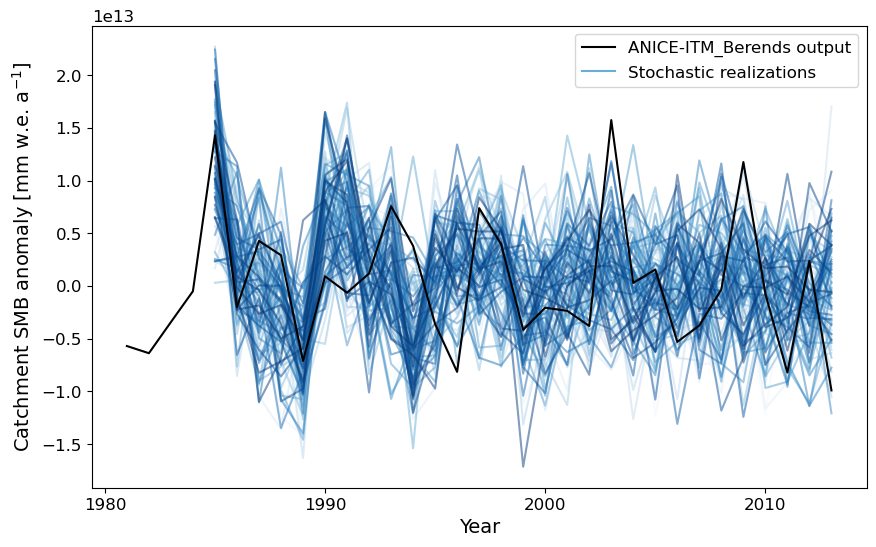

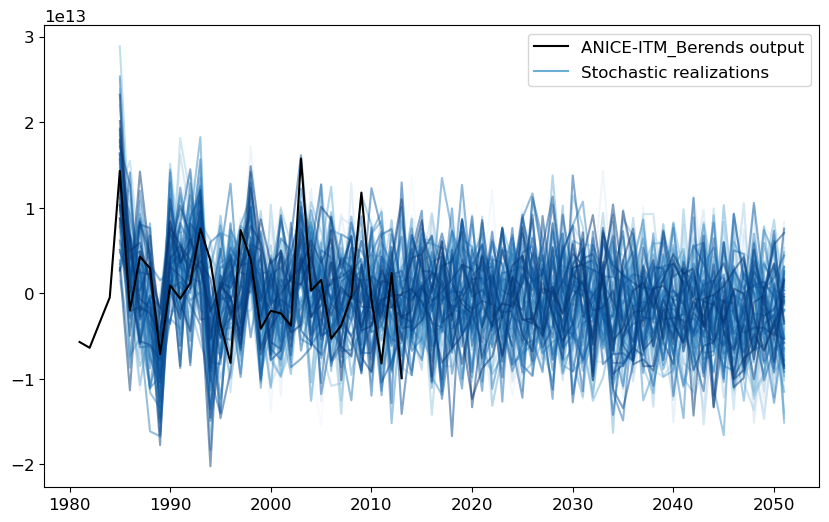

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Generate example time series of SMB for a given catchment
Pre-select AR(1) for annual variability portion
Include noise from sparse covar method

Created on Mon Jun 21 11:54:52 2021

@author: lizz
"""

from sklearn.covariance import GraphicalLassoCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from statsmodels.tsa.ar_model import AutoReg
import scipy.linalg
import glob


model_names = ['ANICE-ITM_Berends', 'CESM_kampenhout', 'dEBM_krebs','HIRHAM_mottram', 
                'NHM-SMAP_niwano', 'RACMO_noel', 'SNOWMODEL_liston']
highlight_model = 'ANICE-ITM_Berends'
highlight_catchment_name, highlight_catchment_id = 'KANGERLUSSUAQ', 101

## Read in time series
def read_catchment_series(fpath, anomaly=True):
    catchment_fpath = fpath
    catchment_tseries = pd.read_csv(catchment_fpath, index_col=0, parse_dates=[0])
    catchment_tseries.mask(catchment_tseries>1e30)
    anomaly_series = catchment_tseries - catchment_tseries.mean()
    if anomaly:
        return anomaly_series
    else:
        return catchment_tseries

def fit_catchment_series(tseries, which_model, comparison_n=range(1,6), 
                         seasonal=True):
    bic_per_n = pd.DataFrame(index=comparison_n, columns=model_names)
    
    if 'multi' in which_model:  ## allow multi-model mode reporting
        for m in model_names:
            for n in comparison_n:
                mod = AutoReg(tseries[m], n, trend='ct', seasonal=seasonal)
                results = mod.fit()
                bic_per_n[m][n] = results.bic
            bic_per_n[m] = pd.to_numeric(bic_per_n[m])
        best_n = bic_per_n.idxmin().mode()[0]
    else:
        for n in comparison_n:
            mod = AutoReg(tseries[which_model], n, trend='ct', seasonal=seasonal)
            results = mod.fit()
            bic_per_n[which_model][n] = results.bic
        bic_per_n[which_model] = pd.to_numeric(bic_per_n[which_model])
        best_n = bic_per_n[which_model].idxmin()
    
    bic_difference = bic_per_n.transform(lambda x: x-x.min())
    
    return best_n, bic_difference

def find_AR_residuals(tseries, which_model, chosen_n=1, 
                         seasonal=False):
    mod = AutoReg(tseries[which_model], chosen_n, trend='ct', seasonal=seasonal)
    results = mod.fit()
    resids = results.resid
    
    return resids

## Time series from AR(n) fits
mod_fits = {m: [] for m in model_names}
mods = {m: [] for m in model_names}

ctmt_fpath = glob.glob('/Users/lizz/Documents/GitHub/Data_unsynced/SMBMIP-processed/*-catchment_{}-tseries.csv'.format(highlight_catchment_id))[0]
s = read_catchment_series(ctmt_fpath, anomaly=True)
a = s.resample('A').sum()
best_n, _ = fit_catchment_series(a, which_model='multi', seasonal=False)
for m in model_names:
    mod = AutoReg(a[m], best_n, trend='ct', seasonal=False).fit()
    fv = mod.fittedvalues
    r = mod.resid
    mod_fits[m] = fv
    mods[m] = mod


## Residuals with spatial information
ar_resids = []
ts_toplot = []
for i in range(1, 200):
    # print(i)
    ctmt_fpath = glob.glob('/Users/lizz/Documents/GitHub/Data_unsynced/SMBMIP-processed/*-catchment_{}-tseries.csv'.format(i))[0]
    s = read_catchment_series(ctmt_fpath, anomaly=True)
    a = s.resample('A').sum()
    ts_toplot.append(a)
    r = find_AR_residuals(a, which_model=highlight_model, chosen_n=best_n, seasonal=False)
    ar_resids.append(r)

ar_resids -= np.mean(ar_resids, axis=0) # normalize
emp_C = np.corrcoef(ar_resids)

np.random.seed(0)
X = np.random.multivariate_normal(mean=np.zeros(len(ar_resids)), cov=emp_C, size=len(ar_resids[0]))

gl_model = GraphicalLassoCV()
gl_model.fit(X)
cov_ = gl_model.covariance_

## Now take the Cholesky decomposition of the sparse cov matrix and generate noise with it
L = scipy.linalg.cholesky(cov_, lower=True)
N = np.random.normal(size=np.shape(ar_resids)) # draws from normal dist

D = np.diag(np.std(ar_resids,1)) ## diagonal matrix of standard devs
scaled_noise = D @ L @ N


## Plot example time series of resids
## set matplotlib font size defaults
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

noise_realizations = []
## Several realizations
for j in range(100):
    Nj = np.random.normal(size=np.shape(ar_resids))
    noise_j = D @ L @ Nj
    noise_realizations.append(noise_j[highlight_catchment_id-1])
noise_colors=cm.get_cmap('Blues')

## Plot a sum of the two
fig2, ax2 = plt.subplots(figsize=(10,6))
for k in range(len(noise_realizations)):
    ax2.plot(mods[highlight_model].predict(best_n, len(a)-1, dynamic=best_n)
             +noise_realizations[k], 
            color=noise_colors(k/len(noise_realizations)), alpha=0.5)
ax2.plot(ts_toplot[highlight_catchment_id-1][highlight_model], color='k',
         label='{} output'.format(highlight_model))
ax2.plot(np.NaN, np.NaN, color=noise_colors(0.5), label='Stochastic realizations')
ax2.set(xlabel='Year', ylabel=r'Catchment SMB anomaly [mm w.e. a$^{-1}$]',
        xticks=(np.datetime64('1980-01-01'), np.datetime64('1990-01-01'),
                np.datetime64('2000-01-01'), np.datetime64('2010-01-01')),
        xticklabels=(1980,1990,2000,2010))
ax2.legend(loc='best')
plt.show()

## Future forecast
yrs_after_1980 = 70
noise_into_future = []
for j in range(100):
    Nj = np.random.normal(size=(len(ar_resids), yrs_after_1980))
    noise_j = D @ L @ Nj
    noise_into_future.append(noise_j[highlight_catchment_id-1])

fig3, ax3 = plt.subplots(figsize=(10,6))
for k in range(len(noise_into_future)):
    ax3.plot(mods[highlight_model].predict(best_n, yrs_after_1980, dynamic=2*best_n)
             +noise_into_future[k][best_n-1::], 
            color=noise_colors(k/len(noise_realizations)), alpha=0.5)
ax3.plot(ts_toplot[highlight_catchment_id-1][highlight_model], color='k',
         label='{} output'.format(highlight_model))
ax3.plot(np.NaN, np.NaN, color=noise_colors(0.5), label='Stochastic realizations')
# ax2.set(xlabel='Year', ylabel=r'Catchment SMB anomaly [mm w.e. a$^{-1}$]',
#         xticks=(np.datetime64('1980-01-01'), np.datetime64('1990-01-01'),
#                 np.datetime64('2000-01-01'), np.datetime64('2010-01-01')),
#         xticklabels=(1980,1990,2000,2010))
ax3.legend(loc='best')
plt.show()


## Map plot
Read in Kangerlussuaq catchment outline, compute catchment mean, extract point values, and compute anomalies

In [3]:
from shapely.geometry import MultiPoint, Polygon, Point
from shapely.ops import triangulate
from scipy.spatial import distance
import shapefile
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import pyproj as pyproj
from scipy import interpolate
import datetime
import time
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
###------------------------
### CHOOSE CATCHMENTS
###------------------------
catchments_to_pull = (101,)

###------------------------
### DATA READ-IN  AND PROJECTION
###------------------------

## Read in BedMachine grid to reproject SMB
gl_bed_path ='/Users/lizz/Documents/GitHub/Data_unsynced/BedMachine-Greenland/BedMachineGreenland-2017-09-20.nc'
fh = Dataset(gl_bed_path, mode='r')
xx = fh.variables['x'][:].copy() # x-coord (polar stereo (70, 45))
yy = fh.variables['y'][:].copy() # y-coord
ss = fh.variables['surface'][:].copy() # surface elevation
fh.close()

## Read in Mouginot catchments from shapefile
print('Reading in Mouginot catchments')
catchment_fn = '/Users/lizz/Documents/GitHub/Data_unsynced/Greenland-catchments-Mouginot/Greenland_Basins_PS_v1.4.2.'
sf = shapefile.Reader(catchment_fn) 

## Example SMB field read in for grid
print('Reading in example SMB field')
nhm_smb_path = '/Users/lizz/Documents/GitHub/Data_unsynced/SMBMIP/NHM-SMAP_niwano-monthly-ERA-Interim-1980.nc'
fh2 = Dataset(nhm_smb_path, mode='r')
xlon_nhm = fh2.variables['LON'][:].copy() #x-coord (latlon)
ylat_nhm = fh2.variables['LAT'][:].copy() #y-coord (latlon)
fh2.close()

###------------------------
### SET UP SMB REPROJECTION
###------------------------

## Down-sample bed topo
x_3km = xx[::20] # sample at ~3 km resolution
y_3km = yy[::20]
s_3km = ss[::20,::20]

## Down-sample SMB
x_lon_h = xlon_nhm[::10, ::10] 
y_lat_h = ylat_nhm[::10, ::10] # resolution about 10 km

print('Creating reprojected meshgrid')
wgs84 = pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by SMB data
psn_gl = pyproj.Proj("+init=epsg:3413") # Polar Stereographic North used by BedMachine and Mankoff
xs, ys = pyproj.transform(wgs84, psn_gl, x_lon_h, y_lat_h)
Xmat, Ymat = np.meshgrid(x_3km, y_3km) # Downsampled BedMachine coords

Reading in Mouginot catchments
Reading in example SMB field
Creating reprojected meshgrid


/opt/anaconda3/envs/stisp/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/anaconda3/envs/stisp/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/anaconda3/envs/stisp/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

In [5]:
##------------------------
## CREATE FRAMEWORK
##------------------------

## Identify grid points within catchment
pts_all = [(xs.ravel()[k], ys.ravel()[k]) for k in range(len(xs.ravel()))]
pt_ctmts = {i: [] for i in catchments_to_pull}
for i in catchments_to_pull:
    print('Point-checking catchment {}'.format(sf.record(i)['NAME']))
    c = Polygon(sf.shape(i).points)
    pts_in = [Point(p).within(c) for p in pts_all]
    pts = np.asarray(pts_all)[pts_in]
    pt_ctmts[i] = pts

Point-checking catchment KANGERLUSSUAQ


In [20]:
area_for_rescale = c.area ## in projection coordinates, which should be sq m

rescaled_projections = {i: [] for i in range(len(noise_realizations))}
for k in range(len(noise_realizations)):
    pred = mods[highlight_model].predict(best_n, len(a)-1, dynamic=best_n)+noise_realizations[k]
    rp = np.array(pred)/area_for_rescale
    rescaled_projections[k] = rp

In [21]:
rescaled_projections[0]

array([  80.10531754,  138.07359429,  -68.62400816,    5.84892465,
       -205.00583649,  161.72899262,  -37.73312349,   65.28865437,
         20.74352438, -239.3984    ,  -14.3848296 , -104.46855034,
        193.52202115, -125.66263899,  104.44565508,  133.78170766,
       -117.54979389,  -71.18041777,  -28.72434355,  -37.60856718,
        117.08025486,  -53.58894323,    3.39164435,   87.86535289,
       -104.81760942,   -2.18967842,  -94.67079177,  -20.42951761,
        -86.40248555])

In [22]:
df_rp = pd.DataFrame(rescaled_projections)

In [23]:
df_rp

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,80.105318,266.457330,189.328110,301.751997,166.747167,360.647241,333.789434,353.677929,297.441064,206.087855,...,127.774513,129.085220,290.891363,308.237272,200.526308,309.504236,382.544580,211.695041,240.803283,167.480999
1,138.073594,53.533245,-25.876429,-51.927606,177.353879,27.780719,61.035638,-23.821180,-72.021998,35.992587,...,6.583339,26.127613,10.496071,-43.405573,55.633160,123.674918,-20.161163,17.512895,-2.769971,-44.167378
2,-68.624008,31.160467,81.502657,12.087448,-47.658085,26.318506,-147.680774,-33.557135,62.040020,-54.491824,...,12.804501,95.004661,99.451906,1.075259,16.647094,-216.568912,-162.431847,-7.759503,-51.947990,-36.369093
3,5.848925,-264.217180,-52.424960,-81.325360,-20.627942,63.478770,35.976608,-245.574939,12.426725,82.566493,...,-30.277158,7.438113,-215.834675,0.714569,-26.270037,-136.456185,-140.842613,-70.136512,-35.427812,-98.324785
4,-205.005836,-67.212914,-124.144804,-109.109435,-222.972754,-199.612050,34.121158,-279.999716,-284.619951,-203.277787,...,-154.533136,-136.978770,-192.167507,-200.965171,-118.748183,123.006070,-116.432665,-178.346759,-101.342312,-75.180346
5,161.728993,26.784509,151.213586,187.629489,245.017375,148.941199,150.594221,72.832394,205.830959,165.812615,...,98.926260,161.201987,55.530754,196.199120,313.413532,160.697760,207.804735,84.706916,111.263500,176.685636
6,-37.733123,-41.657904,47.734780,50.530242,-24.057447,98.491616,57.386294,169.676254,67.205855,163.089011,...,-23.195195,48.951976,21.686128,171.014399,150.272984,-28.171243,237.702520,99.880086,275.983166,233.798127
7,65.288654,-4.542834,41.350174,177.354973,90.186480,36.802499,125.844007,76.008338,112.013445,180.231084,...,8.406242,127.560905,68.088766,-113.483956,-90.607483,109.530240,7.785556,-31.137714,56.590606,54.479417
8,20.743524,-41.176510,-198.626223,205.623767,2.084940,-31.579138,22.043905,-97.970925,-21.948339,225.668424,...,-15.903201,-70.517374,109.644876,129.120829,44.647019,201.126996,-99.502154,68.871558,-4.957621,-75.720767
9,-239.398400,-158.744061,-46.889207,-217.585226,-216.255017,-148.995341,-98.922972,-49.417002,-157.146052,-95.237394,...,-117.628780,-32.662817,-236.655313,-184.177293,-109.840577,-47.289189,-129.330567,-150.789303,-205.339963,-112.741501


In [45]:
## Create data frames to store per-model data
# model_names = ['ANICE-ITM_Berends', 'CESM_kampenhout', 'dEBM_krebs','HIRHAM_mottram', 
#                 'NHM-SMAP_niwano', 'RACMO_noel', 'SNOWMODEL_liston']
model_names = ['ANICE-ITM_Berends',]
years = range(1980,2010)
start_date = datetime.datetime(years[0],1,1)
end_date = datetime.datetime(years[-1],12,31)
dates = pd.date_range(start=start_date, end=end_date, freq='M')
example_df_per_ctchmnt = {i: 
                  {m: 
                   {n: 
                    {y: pd.DataFrame(columns=('elevation', 
                                                'point_smb'))  for y in years}
                    for n in range(12)}
                     for m in model_names}
                      for i in catchments_to_pull}

###------------------------
### EXTRACT EXAMPLE SMB FIELD FOR CATCHMENT
###------------------------

## Store regridded SMBs for use in each catchment to take all available data
smb_ex_monthly = {i: [] for i in range(12)}

for m in ('ANICE-ITM_Berends',):
    t0 = time.time()
    if m=='CESM_kampenhout':
        vname = 'SMBCORR'
    else:
        vname = 'SMBcorr'
    for y in years:
        ti = time.time()
        fpath = '/Users/lizz/Documents/GitHub/Data_unsynced/SMBMIP/{}-monthly-ERA-Interim-{}.nc'.format(m, y)
        fh = Dataset(fpath, mode='r')
        smb_m = fh.variables[vname][:].copy()
        fh.close()
        d_subset = [d for d in dates if d.year==y]
        for i in range(len(smb_m)): # for each month
            ## downsample SMB
            smb_ds = smb_m[i][::10, ::10]
            ## Sample SMB at each Delaunay triangle and sum
            for j in catchments_to_pull:
                points = pt_ctmts[j]
                elevations = []
                smb_point_vals = smb_ds.ravel()[pts_in] ## go back and revise this to use new pts_in for every catchment
                for p in points:
                    surf_x = (np.abs(x_3km - p[0])).argmin()
                    surf_y = (np.abs(y_3km - p[1])).argmin()
                    elevations.append(s_3km[surf_y, surf_x])
                example_df_per_ctchmnt[j][m][i][y] = example_df_per_ctchmnt[j][m][i][y].assign(elevation=elevations,
                                            point_smb=smb_point_vals)
                
        tf = time.time()
        print('Finished processing year {} in time {}s'.format(y, tf-ti))
    t1 = time.time()
    print('Finished processing model {} in time {}'.format(m, t1-t0))

Finished processing year 1980 in time 1.508401870727539s
Finished processing year 1981 in time 1.3735888004302979s
Finished processing year 1982 in time 1.2604320049285889s
Finished processing year 1983 in time 1.2549331188201904s
Finished processing year 1984 in time 1.281965970993042s
Finished processing year 1985 in time 1.2935068607330322s
Finished processing year 1986 in time 1.2620770931243896s
Finished processing year 1987 in time 1.2670941352844238s
Finished processing year 1988 in time 1.263031005859375s
Finished processing year 1989 in time 1.2701139450073242s
Finished processing year 1990 in time 1.2521300315856934s
Finished processing year 1991 in time 1.254728078842163s
Finished processing year 1992 in time 1.2475008964538574s
Finished processing year 1993 in time 1.2522389888763428s
Finished processing year 1994 in time 1.2375669479370117s
Finished processing year 1995 in time 1.2817368507385254s
Finished processing year 1996 in time 1.4018948078155518s
Finished processin

In [48]:
## Select points for tseries comparison
series_points = [
    (497.73, -2298.93), # near terminus of Kangerlussuaq, in km Easting, Northing
    (397.96, -2342.95), # small positive anomaly, southwest
    (483.06, -2161.00) # farther up in accumulation area
    ]
ser = {'Point 1':[], 'Point 2':[], 'Point 3':[]}
elev = []
for i,p in enumerate(series_points):
    idx = distance.cdist([1000*np.array(p)], pt_ctmts[101]).argmin()
    ts = []
    elev.append(example_df_per_ctchmnt[101]['ANICE-ITM_Berends'][1][1980]['elevation'][idx])
    for y in years:
        for m in range(12):
            d = example_df_per_ctchmnt[101]['ANICE-ITM_Berends'][m][y]['point_smb'][idx]
            ts.append(d)
    ser['Point {}'.format(i+1)] = ts
r = pd.date_range(start='1980', end='2010', freq='M') ## dates for plotting
df = pd.DataFrame(ser, index=r)

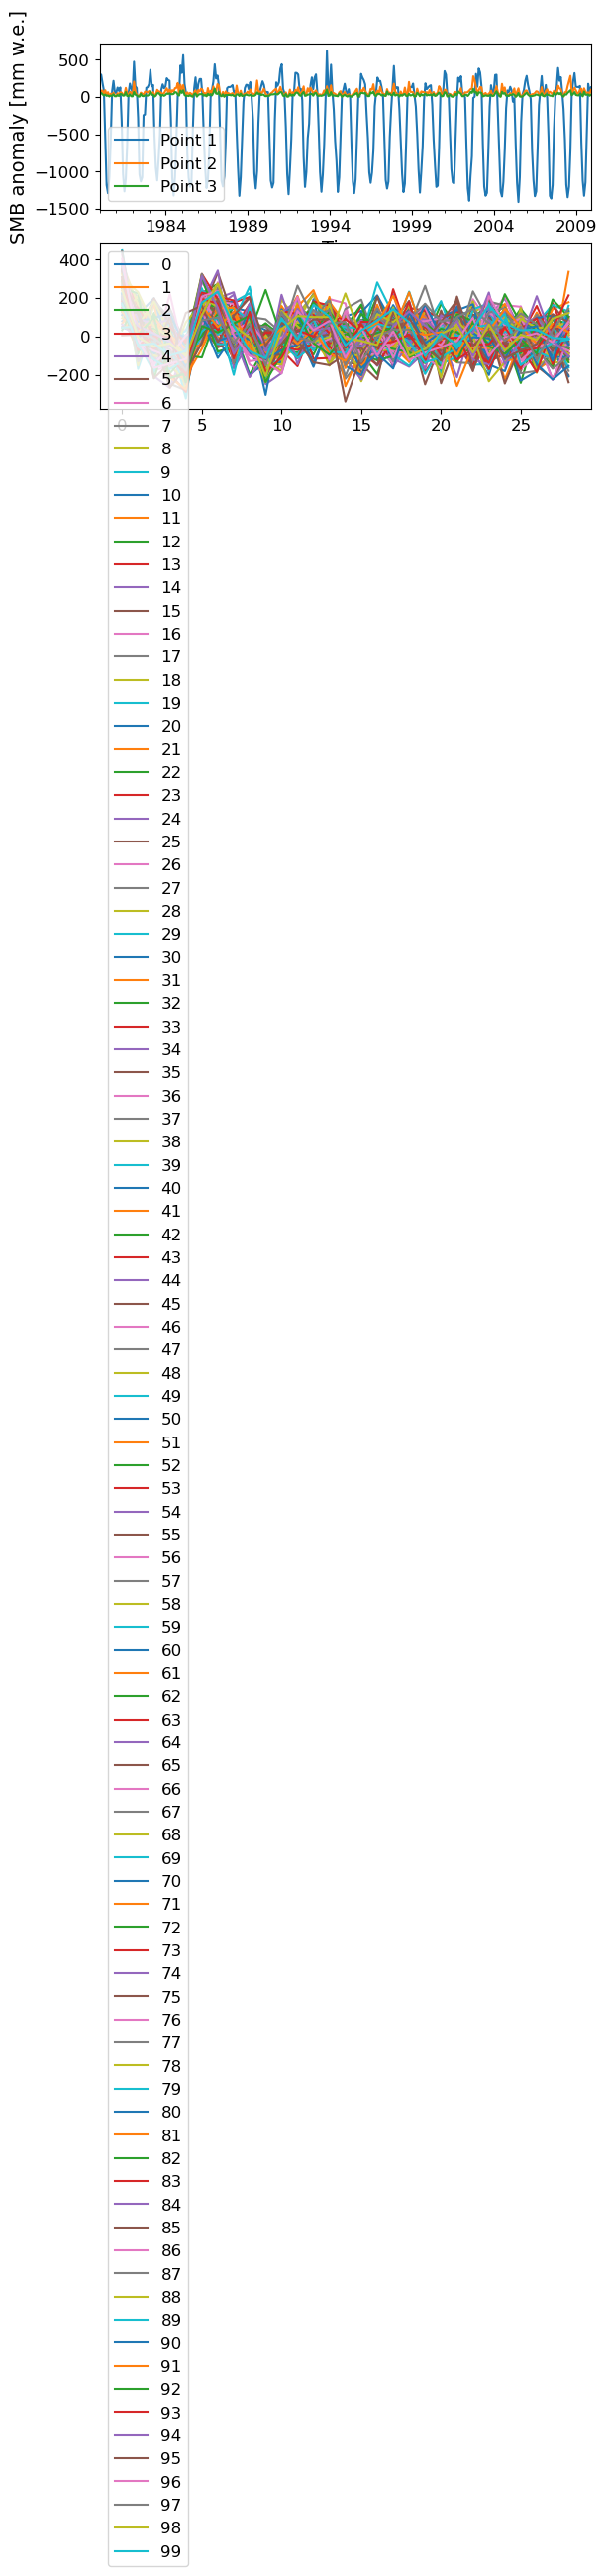

In [49]:
## plot the series

fig, (ax1, ax2) = plt.subplots(2)
df.plot(ax=ax1)
ax1.set(ylabel='SMB anomaly [mm w.e.]', xlabel='Time')
df_rp.plot(ax=ax2)
plt.show()

## Scale by elevation

In [30]:
elev

[141, 2823, 2627]

In [32]:
from stochSMB import segments_fit

In [102]:
df_c = example_df_per_ctchmnt[101]['ANICE-ITM_Berends']
dict_per_month = {i: [] for i in range(12)}
for i in range(12):
    d_to_join = [df_c[i][y] for y in years]
    dict_per_month[i] = pd.concat(d_to_join)

monthly_mbg = {i: [] for i in range(12)}
for i in range(12):
    df_m = dict_per_month[i]
    pt_smbs = np.asarray(df_m.sort_values(by='elevation')['point_smb'])
    anomalies = pt_smbs - np.mean(pt_smbs)
    px, py = segments_fit(np.asarray(df_m.sort_values(by='elevation')['elevation']),
                          # np.asarray(df.sort_values(by='elevation')['point_smb']),
                          anomalies,
                          maxcount=2)
    monthly_mbg[i] = interpolate.interp1d(px,py)
    

In [103]:
monthly_correction = {'Point 1': [], 'Point 2':[], 'Point 3': []}
for j, el in enumerate(elev):
    mc = [monthly_mbg[i](el) for i in range(12)]
    monthly_correction['Point {}'.format(j+1)] = mc
df_mc = pd.DataFrame(monthly_correction)

In [104]:
df_mc

,Point 1,Point 2,Point 3
0,139.3062994268767,-13.03101205659874,3.0452812693378633
1,182.79126617132766,-15.432390116721308,3.5894040900588777
2,102.7947334893532,-11.356928143154903,2.7321448618812383
3,-22.76642123832525,-9.611929880605572,2.543386081334262
4,-502.3527147796693,-5.214797663878045,5.986986245819523
5,-1024.075682616582,18.67276374982407,20.369477642233992
6,-1170.569048205124,43.50480979707466,48.209646792295054
7,-1086.6095569030279,18.497685685903,25.345921474694777
8,-555.7739851758736,-5.2812205052931915,6.831376948197132
9,-40.45081478144393,-9.187389337112464,2.609382257790813


In [105]:
len(df_rp)

29

In [106]:
monthly_preds_p1 = {r[j]: [] for j in range(len(df))} ## create one row for each date
monthly_preds_p2 = {r[j]: [] for j in range(len(df))} ## create one row for each date
monthly_preds_p3 = {r[j]: [] for j in range(len(df))} ## create one row for each date


count = 0
for k in range(len(df)):
    scale_factor_1 = df_mc['Point 1'][k%12]
    scale_factor_2 = df_mc['Point 2'][k%12]
    scale_factor_3 = df_mc['Point 3'][k%12]
    monthly_preds_p1[r[k]] = scale_factor_1 + np.array(df_rp.iloc[count])
    monthly_preds_p2[r[k]] = scale_factor_2 + np.array(df_rp.iloc[count])
    monthly_preds_p3[r[k]] = scale_factor_3 + np.array(df_rp.iloc[count])
    if k%12==11: # if we've reached the end of a year
        count+=1
    if count>28:
        break

In [107]:
df_mpp1 = pd.DataFrame.from_dict(monthly_preds_p1, orient='index')
df_mpp2 = pd.DataFrame.from_dict(monthly_preds_p2, orient='index')
df_mpp3 = pd.DataFrame.from_dict(monthly_preds_p3, orient='index')

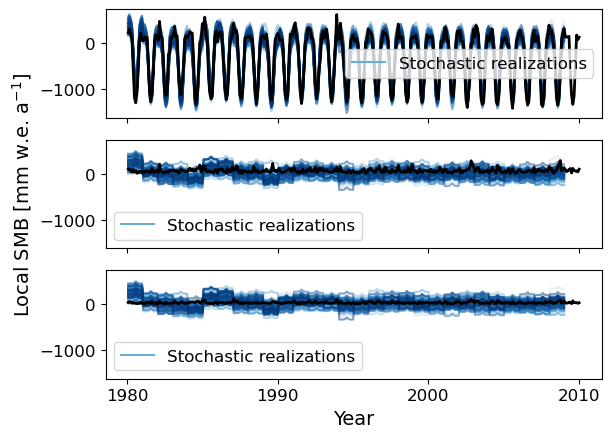

In [108]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
for k in range(len(df_mpp1.columns)): ## plot all the realizations
    ax1.plot(df_mpp1[k], 
           color=noise_colors(k/len(df_mpp1.columns)), alpha=0.5) 
ax1.plot(df['Point 1'], color='k', lw=2.0) #plot the true local SMB from the process model
ax1.plot(np.NaN, np.NaN, color=noise_colors(0.5), label='Stochastic realizations')
ax1.set(#xlabel='Year',
        xticks=(np.datetime64('1980-01-01'), np.datetime64('1990-01-01'),
                np.datetime64('2000-01-01'), np.datetime64('2010-01-01')),
        xticklabels=(1980,1990,2000,2010))
ax1.legend(loc='best')

for k in range(len(df_mpp2.columns)): ## plot all the realizations
    ax2.plot(df_mpp2[k], 
           color=noise_colors(k/len(df_mpp2.columns)), alpha=0.5) 
ax2.plot(df['Point 2'], color='k', lw=2.0) #plot the true local SMB from the process model
ax2.plot(np.NaN, np.NaN, color=noise_colors(0.5), label='Stochastic realizations')
ax2.set(#xlabel='Year', 
        ylabel=r'Local SMB [mm w.e. a$^{-1}$]',
        xticks=(np.datetime64('1980-01-01'), np.datetime64('1990-01-01'),
                np.datetime64('2000-01-01'), np.datetime64('2010-01-01')),
        xticklabels=(1980,1990,2000,2010))
ax2.legend(loc='best')

for k in range(len(df_mpp3.columns)): ## plot all the realizations
    ax3.plot(df_mpp3[k], 
           color=noise_colors(k/len(df_mpp3.columns)), alpha=0.5) 
ax3.plot(df['Point 3'], color='k', lw=2.0) #plot the true local SMB from the process model
ax3.plot(np.NaN, np.NaN, color=noise_colors(0.5), label='Stochastic realizations')
ax3.set(xlabel='Year',
        xticks=(np.datetime64('1980-01-01'), np.datetime64('1990-01-01'),
                np.datetime64('2000-01-01'), np.datetime64('2010-01-01')),
        xticklabels=(1980,1990,2000,2010))
ax3.legend(loc='best')
plt.show()

In [88]:
len(df_mpp1.columns)

100